In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

## 1. Data Loading

In [2]:
folder_path = '/Users/samykobbite/Documents/Projects/QRT'

In [3]:
x_train_original = pd.read_csv(folder_path + '/x_train_Lafd4AH.csv', index_col = 'ID')
x_test_original = pd.read_csv(folder_path + '/x_test_c7ETL4q.csv', index_col= 'ID')


In [4]:
x_train = pd.read_csv(folder_path + '/x_train_Lafd4AH.csv')
y_train = pd.read_csv(folder_path + '/y_train_JQU4vbI.csv')

train_complete = pd.concat([x_train, y_train], axis = 1)
train_complete.set_index(['STOCK', 'DATE'], inplace = True)
train_complete = train_complete.sort_values(by = ['STOCK','DATE'])

x_test = pd.read_csv(folder_path + '/x_test_c7ETL4q.csv')
x_test.set_index(['STOCK', 'DATE'], inplace = True)
x_test = x_test.sort_values(by = ['STOCK', 'DATE'])

train_complete

ID  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY     RET_1  \
STOCK DATE                                                                     
0     1       2377        37              12       5            94 -0.005967   
      4       5198        37              12       5            94  0.001348   
      5       8017        37              12       5            94 -0.014405   
      11     20826        37              12       5            94  0.008938   
      21     33843        37              12       5            94 -0.006523   
...            ...       ...             ...     ...           ...       ...   
5716  206   391556        50              17       7           114  0.029552   
      208   394490        50              17       7           114  0.008316   
      210   400150        50              17       7           114 -0.004633   
      211   403129        50              17       7           114  0.010883   
      221   416228        50              17       7           114 -0.021391   

            VOLUME_1     RET_2  VOLUME_2     RET_3  ...    RET_17  VOLUME_17  \
STOCK DATE                                          ...                        
0     1     0.136699  0.009031 -0.003109  0.008296  ... -0.007660  -0.585497   
      4    -0.269520  0.011100 -0.085622  0.012023  ...  0.007867   0.071338   
      5     0.192655  0.003614  0.353804  0.011156  ... -0.005843  -0.405562   
      11    0.430916  0.002662  0.175444  0.002490  ...  0.011266   0.079711   
      21   -0.060371 -0.007632 -0.037806  0.004756  ... -0.007224  -0.161117   
...              ...       ...       ...       ...  ...       ...        ...   
5716  206  -0.075091 -0.001428 -0.026934  0.007191  ...  0.017026   0.170516   
      208   0.028099 -0.006688 -0.169174  0.018022  ...  0.002887  -0.050408   
      210  -0.173518  0.001687 -0.231339  0.004663  ... -0.015320  -0.149467   
      211   0.172313  0.008844 -0.198001  0.001833  ... -0.008823  -0.026153   
      221  -0.176100  0.024657 -0.189710  0.006064  ... -0.002706  -0.227997   

              RET_18  VOLUME_18    RET_19  VOLUME_19    RET_20  VOLUME_20  \
STOCK DATE                                                                  
0     1    -0.001063  -0.351363  0.005127  -0.324675 -0.019275  -0.291751   
      4     0.007733  -0.405243 -0.003276  -0.424336 -0.010489  -0.050591   
      5     0.002930  -0.315935  0.010462  -0.474957 -0.003541  -0.260130   
      11    0.019038  -0.230167 -0.000287  -0.312123  0.008682  -0.226628   
      21   -0.001461  -0.095494  0.012667   0.471895 -0.038752   1.532045   
...              ...        ...       ...        ...       ...        ...   
5716  206   0.002276  -0.106224 -0.034597   0.123750 -0.015676  -0.228186   
      208   0.008736  -0.159294  0.027350  -0.022922  0.008186  -0.080569   
      210  -0.035810  -0.262389  0.000896  -0.172450  0.008586  -0.482171   
      211  -0.011428  -0.142636  0.011253  -0.224195  0.000609  -0.341878   
      221   0.032402  -1.587177 -0.043803  -0.387343 -0.006897  -0.467651   

                ID    RET  
STOCK DATE                 
0     1       2377  False  
      4       5198  False  
      5       8017   True  
      11     20826   True  
      21     33843  False  
...            ...    ...  
5716  206   391556   True  
      208   394490   True  
      210   400150  False  
      211   403129   True  
      221   416228   True  

[418595 rows x 47 columns]

## 2. Dataframe exploration

Let's begin by trying to understand the way the dataframe is set.

In [5]:
print('train complete: ',len(train_complete.index.get_level_values('DATE').unique()))
print('test: ', len(x_test.index.get_level_values('DATE').unique()))

common_set = set(train_complete.index.get_level_values('DATE').unique()).intersection(set(x_test.index.get_level_values('DATE').unique()))
if len(common_set) == 0:
    print('No common dates in the train and test set')
else:
    print('The following dates appear both in the train set and in the test set')

train complete:  156
test:  68
No common dates in the train and test set


As expected no same dates are both in the train and test set (Potentially we could have a common date in the two sets, but with different stocks, (which would still have been helpful)). 

Now, as for every date, we have data on the 20 previous days, let's look if a part of that data overlaps with another date. We should do this for every date available, with at least one stock. Ideally we would like to see one stock with all the available dates, so that we can use only that specific stock to verify that there is no overlapping. Let's see if such a stock exists.

In [6]:
all_stocks = train_complete.index.get_level_values('STOCK').unique()
all_dates = train_complete.index.get_level_values('DATE').unique()

all_dates_test = x_test.index.get_level_values('DATE').unique()
all_stock_test = x_test.index.get_level_values('STOCK').unique()

In [7]:
for stock in list(sorted(all_stocks)):
    if len(train_complete.xs(stock, level = 'STOCK').index) == len(all_dates):
        print(f'The stock {stock} has all the dates available in the entire dataframe')

The stock 4 has all the dates available in the entire dataframe
The stock 8 has all the dates available in the entire dataframe
The stock 45 has all the dates available in the entire dataframe
The stock 59 has all the dates available in the entire dataframe
The stock 65 has all the dates available in the entire dataframe
The stock 72 has all the dates available in the entire dataframe
The stock 84 has all the dates available in the entire dataframe
The stock 86 has all the dates available in the entire dataframe
The stock 97 has all the dates available in the entire dataframe
The stock 133 has all the dates available in the entire dataframe
The stock 143 has all the dates available in the entire dataframe
The stock 184 has all the dates available in the entire dataframe
The stock 213 has all the dates available in the entire dataframe
The stock 216 has all the dates available in the entire dataframe
The stock 219 has all the dates available in the entire dataframe
The stock 348 has all

In [8]:
# quick verification here
list(train_complete.xs(4, level= 'STOCK').index) == sorted(all_dates)

True

As one can see from above, for a great number of stocks, we have access to the returns and volumes for all the possible dates. Out of them all, let's chose the first one (stock 4) to continue our research.

In [9]:
list_volumes = [x for x in train_complete.columns if 'VOL' in x] # Here is the list of the nams of all the volumes columns (VOL_1, VOL_2 etc...).
list_returns = [x for x in train_complete.columns if 'RET_' in x] # Same but with the returns columns. 

df_overlap_check = train_complete[list_volumes]
df_overlap_check = df_overlap_check.xs(4, level = 'STOCK')
df_overlap_check = df_overlap_check.T

df_overlap_check_test = x_test[list_volumes]
df_overlap_check_test = df_overlap_check_test.xs(4, level = 'STOCK')
df_overlap_check_test = df_overlap_check_test.T

df_overlap_check_all = pd.concat([df_overlap_check, df_overlap_check_test], axis = 1)
df_overlap_check_all


DATE,0,1,4,5,6,7,9,10,11,14,...,199,200,201,205,207,212,215,217,219,222
VOLUME_1,-0.096282,-0.317288,-0.494664,-0.133664,-0.252580,0.001409,0.200767,0.251550,-0.208473,-0.565145,...,2.986271,-0.179042,0.060937,-1.701998,0.096054,-0.121420,0.019965,0.123829,-0.468308,-0.563403
VOLUME_2,0.084771,-0.294487,0.062093,-0.118268,0.558520,-0.466052,-0.584412,0.016733,2.337354,-0.386914,...,4.134511,-0.264025,-0.332356,-1.595282,0.081876,0.086636,0.208660,-0.512324,-0.292551,-0.485029
VOLUME_3,-0.298777,-0.474041,-0.296465,-0.204353,0.485666,-0.051299,-0.154737,-0.022546,0.399977,-0.603694,...,2.847189,0.415192,-0.428361,-0.606118,-0.145373,0.038543,-0.145016,-0.159418,-0.387345,-0.626396
VOLUME_4,-0.157421,-0.291089,-0.344545,0.009205,2.837649,-0.531435,-0.385105,0.015995,-0.226549,-0.236186,...,3.780700,0.232432,-0.255146,-0.391699,-0.219003,-0.179854,-0.278191,-0.375335,-0.254541,-0.680644
VOLUME_5,0.091455,-0.247527,-0.507236,-0.126031,5.836195,-0.301838,-0.516493,-0.507305,-0.206042,-0.349631,...,10.500202,0.159945,-0.342961,-0.019106,-0.339827,-0.235209,-0.202917,-0.435363,0.196084,-0.507732
VOLUME_6,-0.405978,-0.596993,-0.540698,-0.331146,8.356376,-0.359313,-0.576013,-0.529518,0.243631,-0.453654,...,40.008534,0.603109,-0.217986,-0.545521,-0.480515,0.041222,-0.165137,0.280932,-0.302948,-0.191107
VOLUME_7,-0.389777,-0.381829,-0.452077,-0.292462,1.425454,-0.258338,-0.585566,-0.296477,-0.393743,0.598318,...,0.343348,0.440864,-0.060946,-0.564191,-0.496708,-0.047223,-0.160948,-0.196806,-0.522655,0.182912
VOLUME_8,-0.701838,-0.478049,-0.566228,0.091320,0.203508,1.810415,-0.544718,-0.306228,-0.192819,0.639074,...,-0.085065,0.099920,-0.374266,-0.523856,-0.574399,-0.077225,0.156292,-0.058847,0.190284,-0.373817
VOLUME_9,-0.229531,-0.548480,-0.304521,-0.481230,-0.134098,1.968178,-0.476962,0.350099,-0.100173,4.184519,...,-0.406908,-0.139075,-0.298936,-0.220787,-0.509958,-0.237360,0.025096,-0.084717,-0.190651,-0.506828
VOLUME_10,0.543460,-0.350948,-0.134930,-0.330055,0.116355,-0.202251,-0.319424,-0.403343,0.435329,1.132366,...,-0.267099,0.357724,-0.349356,0.111857,-0.086079,-0.065348,-0.178333,0.037257,-0.488459,-0.113350


In [10]:
def check_shifted_columns(df, df_name = ''):
    count = 0
    for x in df.columns:
        col_reference = df[x]
        shift_results = {}
        for column in df.columns:
            if column != 1: 
                for shift_value in range(1, 20):
                    shifted_col = df[column].shift(shift_value)
                    if shifted_col.equals(col_reference) and not shifted_col.isna().all():
                        shift_results[column] = shift_value
                        break
        if shift_results:
            print(f"Columns that are like column {x} but with some shift :")
            for col, shift_value in shift_results.items():
                print(f"{col} corresponds to a shift of {shift_value} row(s)")
                count += 1
    if count == 0:
        print(f"No column in the dataframe {df_name} correspond to another one with a shift.")

In [11]:
check_shifted_columns(df_overlap_check_all, 'df_overlap_check_all')

No column in the dataframe df_overlap_check_all correspond to another one with a shift.


As a conclusion we now are sure that there is no temporal information that is available to our use (which would have been the quivalent of an arbitrage opportunity here). Hence we will focus on other type of indicators/information.

We will try to visualize the data, in order to understand it better. But before we do that, let's get rid of the NaN in our dataframes, so that we don't have any issues computing correlations or other statistics further away.

## 3. Handling of the NaN values

In order to have a valid computation of the correlations, it is better to have a dataframe with no NaN values. Therefore, from now on we will handle that issue by filling the NaN. Many different techniques exist to fill the Nan values. Basing ourselves on the result of the following paper: Chen, A. Y., & McCoy, J. (2022). Missing Values Handling for Machine Learning Portfolios. arXiv. https://doi.org/10.48550/arXiv.2207.13071, we will use a cross sectionnal mean.

Indeed, as explained in the paper, cross sectional mean is very useful because it allows us to fill the data with no look ahead bias and in general it gives as good as (if not better) results than more sophisticated techniques. 

More precisely, what we will do here, is that for every single date, we will replace the missing value of a stock for a specific column, with the mean of the values for the other stocks (at that very date, so there is no look ahead bias).

But first let's have a look at how many NaNs we have and where they are.

In [12]:
print(train_complete.isna().sum().to_dict().items())
print(x_test.isna().sum().to_dict().items())

dict_items([('ID', 0), ('INDUSTRY', 0), ('INDUSTRY_GROUP', 0), ('SECTOR', 0), ('SUB_INDUSTRY', 0), ('RET_1', 2359), ('VOLUME_1', 65025), ('RET_2', 2465), ('VOLUME_2', 66386), ('RET_3', 2507), ('VOLUME_3', 67819), ('RET_4', 2544), ('VOLUME_4', 70997), ('RET_5', 2584), ('VOLUME_5', 74693), ('RET_6', 2597), ('VOLUME_6', 74714), ('RET_7', 2585), ('VOLUME_7', 73853), ('RET_8', 2623), ('VOLUME_8', 73898), ('RET_9', 2682), ('VOLUME_9', 73298), ('RET_10', 2692), ('VOLUME_10', 73305), ('RET_11', 2961), ('VOLUME_11', 72025), ('RET_12', 3186), ('VOLUME_12', 62523), ('RET_13', 3360), ('VOLUME_13', 59008), ('RET_14', 4413), ('VOLUME_14', 60929), ('RET_15', 4990), ('VOLUME_15', 66373), ('RET_16', 5280), ('VOLUME_16', 67262), ('RET_17', 5301), ('VOLUME_17', 62314), ('RET_18', 5307), ('VOLUME_18', 67586), ('RET_19', 5313), ('VOLUME_19', 67329), ('RET_20', 5341), ('VOLUME_20', 67857), ('RET', 0)])
dict_items([('ID', 0), ('INDUSTRY', 0), ('INDUSTRY_GROUP', 0), ('SECTOR', 0), ('SUB_INDUSTRY', 0), ('RET_1

For all the stocks we have information on the sector/industry in which it belongs, but we are sometimes lacking some information on the returns and volumes. Let's take a closer look.

In [13]:
# With this function, we make sure that we are able to fill the NaN values in a specific column with the mean of the values of that specific column, ON A SPECIFIC DATE (no temporal biais)
# For instance if for stock 0 at date 1, we lack the data on the column RET_10, we fill it with the mean of RET_10 values on date 1.

def impute_missing_values(group):
    return group.apply(lambda x: x.fillna(x.mean()), axis=0)

train_complete_filled = train_complete.groupby(level='DATE').apply(impute_missing_values).droplevel(0).sort_values(['STOCK', 'DATE'])
x_test_filled = x_test.groupby(level='DATE').apply(impute_missing_values).droplevel(0).sort_values(['STOCK', 'DATE'])

In [14]:
print(train_complete_filled.isna().sum().to_dict().items())
print(x_test_filled.isna().sum().to_dict().items())

dict_items([('ID', 0), ('INDUSTRY', 0), ('INDUSTRY_GROUP', 0), ('SECTOR', 0), ('SUB_INDUSTRY', 0), ('RET_1', 2199), ('VOLUME_1', 2199), ('RET_2', 2199), ('VOLUME_2', 2199), ('RET_3', 2199), ('VOLUME_3', 2199), ('RET_4', 2199), ('VOLUME_4', 2199), ('RET_5', 2199), ('VOLUME_5', 2199), ('RET_6', 2199), ('VOLUME_6', 2199), ('RET_7', 2199), ('VOLUME_7', 2199), ('RET_8', 2199), ('VOLUME_8', 2199), ('RET_9', 2199), ('VOLUME_9', 2199), ('RET_10', 2199), ('VOLUME_10', 2199), ('RET_11', 2199), ('VOLUME_11', 2199), ('RET_12', 2199), ('VOLUME_12', 2199), ('RET_13', 2199), ('VOLUME_13', 2199), ('RET_14', 2199), ('VOLUME_14', 2199), ('RET_15', 2199), ('VOLUME_15', 2199), ('RET_16', 2199), ('VOLUME_16', 2199), ('RET_17', 2199), ('VOLUME_17', 2199), ('RET_18', 2199), ('VOLUME_18', 2199), ('RET_19', 2199), ('VOLUME_19', 2199), ('RET_20', 2199), ('VOLUME_20', 2199), ('RET', 0)])
dict_items([('ID', 0), ('INDUSTRY', 0), ('INDUSTRY_GROUP', 0), ('SECTOR', 0), ('SUB_INDUSTRY', 0), ('RET_1', 0), ('VOLUME_1', 

As we can see from the above cell, we were able to fill all the missing values of the test set with our technique, but not of the train set. This is not that surprising. It normally simply means that, for some missing values, on a specific date, an entire column was missing (i.e for that column we had no information on no stock on that date). Let's verify if it is indeed what happened.

In [15]:
# We verify if there is a date for which an entire column of type RET_ or VOL_ is empty
for date in all_dates:
    if train_complete_filled[list_volumes + list_returns].xs(date, level = 'DATE').isna().all().any():
        print(date)

42


In [16]:
train_complete_filled.xs(42, level = 'DATE')

,ID,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,...,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,ID,RET
STOCK,,,,,,,,,,,,,,,,,,,,,
2,68419,18,5,3,44,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68419,True
3,68420,43,15,6,104,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68420,False
4,68421,57,20,8,142,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68421,True
8,68422,1,1,1,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68422,False
45,68423,52,18,7,121,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68423,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,70613,47,16,7,109,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70613,False
5703,70614,32,10,4,77,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70614,True
5705,70615,35,12,5,91,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70615,True


Indeed, one can see above that for the date 42, we have no information whatsoever on the RET_i and VOL_i columns (for i int in [0,20]). We now have to solve that issue. One thing that is sure, is that we do not want to bring any look ahead bias. (Hence we won't use other dates to fill this one). Then, we have two (main) solutions:

- Either we fill the columns with 0
- Either we delete the date 42.

As volumes are relatives, and returns are close to zero, the missing values should not be very far from zero. Yet, putting them all to zeros could still bring a bias when we train the algorithm later on. We do not want that.

On the other side, by deleting date 42, we might lose some information (which stocks were well ranked that date), yet, as we have 155 other dates, it is very unlikely that the specific data of date 42 is really valuable. As I have to make a choice, I rather chose to take the risk of loosing a little bit of information rather than make the entirety of my model biased. Hence, I chose to delete the date 42.

In [17]:
train_complete_filled = train_complete_filled.drop(index=42, level='DATE')
print("New number of dates in the dataframe: ", len(train_complete_filled.index.get_level_values('DATE').unique()))
print(list(train_complete_filled.index.get_level_values('DATE').unique()))
print(train_complete_filled.isna().sum().to_dict().items())
train_complete_filled

New number of dates in the dataframe:  155
[1, 4, 5, 11, 21, 22, 28, 32, 39, 41, 51, 54, 55, 57, 58, 60, 64, 65, 67, 68, 70, 71, 74, 80, 82, 86, 89, 90, 91, 92, 93, 96, 97, 98, 100, 103, 104, 108, 109, 115, 116, 125, 128, 130, 134, 135, 136, 138, 143, 149, 150, 153, 156, 160, 161, 163, 169, 173, 174, 179, 180, 181, 188, 189, 196, 206, 208, 210, 211, 221, 9, 14, 38, 43, 44, 47, 48, 49, 52, 59, 75, 76, 77, 81, 105, 107, 110, 121, 124, 129, 137, 142, 144, 146, 148, 154, 184, 195, 197, 202, 209, 213, 220, 0, 6, 7, 10, 18, 19, 20, 25, 33, 34, 35, 36, 40, 46, 50, 53, 56, 61, 62, 69, 84, 85, 88, 94, 99, 101, 111, 117, 120, 122, 123, 127, 141, 147, 158, 164, 165, 166, 168, 171, 177, 182, 183, 186, 193, 194, 198, 203, 204, 214, 218, 223]
dict_items([('ID', 0), ('INDUSTRY', 0), ('INDUSTRY_GROUP', 0), ('SECTOR', 0), ('SUB_INDUSTRY', 0), ('RET_1', 0), ('VOLUME_1', 0), ('RET_2', 0), ('VOLUME_2', 0), ('RET_3', 0), ('VOLUME_3', 0), ('RET_4', 0), ('VOLUME_4', 0), ('RET_5', 0), ('VOLUME_5', 0), ('RET_6

ID  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY     RET_1  \
STOCK DATE                                                                     
0     1       2377        37              12       5            94 -0.005967   
      4       5198        37              12       5            94  0.001348   
      5       8017        37              12       5            94 -0.014405   
      11     20826        37              12       5            94  0.008938   
      21     33843        37              12       5            94 -0.006523   
...            ...       ...             ...     ...           ...       ...   
5716  206   391556        50              17       7           114  0.029552   
      208   394490        50              17       7           114  0.008316   
      210   400150        50              17       7           114 -0.004633   
      211   403129        50              17       7           114  0.010883   
      221   416228        50              17       7           114 -0.021391   

            VOLUME_1     RET_2  VOLUME_2     RET_3  ...    RET_17  VOLUME_17  \
STOCK DATE                                          ...                        
0     1     0.136699  0.009031 -0.003109  0.008296  ... -0.007660  -0.585497   
      4    -0.269520  0.011100 -0.085622  0.012023  ...  0.007867   0.071338   
      5     0.192655  0.003614  0.353804  0.011156  ... -0.005843  -0.405562   
      11    0.430916  0.002662  0.175444  0.002490  ...  0.011266   0.079711   
      21   -0.060371 -0.007632 -0.037806  0.004756  ... -0.007224  -0.161117   
...              ...       ...       ...       ...  ...       ...        ...   
5716  206  -0.075091 -0.001428 -0.026934  0.007191  ...  0.017026   0.170516   
      208   0.028099 -0.006688 -0.169174  0.018022  ...  0.002887  -0.050408   
      210  -0.173518  0.001687 -0.231339  0.004663  ... -0.015320  -0.149467   
      211   0.172313  0.008844 -0.198001  0.001833  ... -0.008823  -0.026153   
      221  -0.176100  0.024657 -0.189710  0.006064  ... -0.002706  -0.227997   

              RET_18  VOLUME_18    RET_19  VOLUME_19    RET_20  VOLUME_20  \
STOCK DATE                                                                  
0     1    -0.001063  -0.351363  0.005127  -0.324675 -0.019275  -0.291751   
      4     0.007733  -0.405243 -0.003276  -0.424336 -0.010489  -0.050591   
      5     0.002930  -0.315935  0.010462  -0.474957 -0.003541  -0.260130   
      11    0.019038  -0.230167 -0.000287  -0.312123  0.008682  -0.226628   
      21   -0.001461  -0.095494  0.012667   0.471895 -0.038752   1.532045   
...              ...        ...       ...        ...       ...        ...   
5716  206   0.002276  -0.106224 -0.034597   0.123750 -0.015676  -0.228186   
      208   0.008736  -0.159294  0.027350  -0.022922  0.008186  -0.080569   
      210  -0.035810  -0.262389  0.000896  -0.172450  0.008586  -0.482171   
      211  -0.011428  -0.142636  0.011253  -0.224195  0.000609  -0.341878   
      221   0.032402  -1.587177 -0.043803  -0.387343 -0.006897  -0.467651   

                ID    RET  
STOCK DATE                 
0     1       2377  False  
      4       5198  False  
      5       8017   True  
      11     20826   True  
      21     33843  False  
...            ...    ...  
5716  206   391556   True  
      208   394490   True  
      210   400150  False  
      211   403129   True  
      221   416228   True  

[416396 rows x 47 columns]

Great, we now have two completely filled dataframes. We will be able to use them to train/test our model, and we can now compute statistics in an easier way.

## 4. Adding some interesting features

Now that we have two filled dataframes, we can try to complete them with some basic features that can later prove to be useful : Volatility, Cumulative returns, EMA, etc... 

a. Cumulative returns

In [18]:
def add_cumulative_returns(df, return_columns):
    n = len(return_columns)
    for i in range(1,21):
            df[f'CR_{i}'] = (df[return_columns[(i-1):]] + 1).prod(axis=1) - 1
    return df

In [19]:
train_complete_filled = add_cumulative_returns(train_complete_filled, list_returns)
x_test_filled = add_cumulative_returns(x_test_filled, list_returns)

b. Volatility

In [20]:
def add_volatility(df, return_columns):
    df['VOLATILITY'] = df[return_columns].std(axis=1)*100
    return df

In [21]:
train_complete_filled = add_volatility(train_complete_filled, list_returns)
x_test_filled = add_volatility(x_test_filled, list_returns)

c. EMA

In [22]:
def calculate_ema(df, list_columns, feature,span=10):
    df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
    return df

In [23]:
train_complete_filled = calculate_ema(train_complete_filled, list_returns, 'RET')
x_test_filled = calculate_ema(x_test_filled, list_returns, 'RET')

train_complete_filled = calculate_ema(train_complete_filled, list_returns, 'RET', 5)
x_test_filled = calculate_ema(x_test_filled, list_returns, 'RET', 5)

/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/173434963.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/173434963.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/173434963.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx0000

d. Rolling Volatility

In [24]:
def calculate_rolling_std(df, return_columns, window = 10):
    df[f'ROLLING_VOLATILITY_{window}'] = df[return_columns].rolling(window, axis=1).std().iloc[:, -1]*100
    return df

In [25]:
train_complete_filled = calculate_rolling_std(train_complete_filled, list_returns)
x_test_filled = calculate_rolling_std(x_test_filled, list_returns)

train_complete_filled = calculate_rolling_std(train_complete_filled, list_returns,5)
x_test_filled = calculate_rolling_std(x_test_filled, list_returns, 5)

/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/3065216043.py:2: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df[f'ROLLING_VOLATILITY_{window}'] = df[return_columns].rolling(window, axis=1).std().iloc[:, -1]*100
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/3065216043.py:2: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df[f'ROLLING_VOLATILITY_{window}'] = df[return_columns].rolling(window, axis=1).std().iloc[:, -1]*100
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/3065216043.py:2: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df[f'ROLLING_VOLATILITY_{window}'] = df[return_columns].rolling(window, axis=1).std().iloc[:, -1]*100
/var/folders/7w/1lb

e. Mean of the returns and volumes

In [26]:
def compute_mean(df,list_columns, feature):
    df[f'MEAN_{feature}'] = df[list_columns].mean(axis = 1)
    return df

In [27]:
train_complete_filled = compute_mean(train_complete_filled, list_returns, 'RET')
train_complete_filled = compute_mean(train_complete_filled, list_volumes, 'VOLUME')

x_test_filled = compute_mean(x_test_filled, list_returns, 'RET')
x_test_filled = compute_mean(x_test_filled, list_volumes, 'VOLUME')

f. EMA of cumulative returns

In [28]:
list_cumulative_returns = [x for x in train_complete.columns if 'CR_' in x]

train_complete_filled = calculate_ema(train_complete_filled, list_returns, 'CR')
x_test_filled = calculate_ema(x_test_filled, list_returns, 'CR')

train_complete_filled = calculate_ema(train_complete_filled, list_returns, 'CR', 5)
x_test_filled = calculate_ema(x_test_filled, list_returns, 'CR', 5)

/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/173434963.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/173434963.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_29446/173434963.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  df[f'EMA_{feature}_{span}'] = df[list_columns].ewm(span=span, axis=1, adjust=False).mean().iloc[:, -1]
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx0000

g. Number of positives returns/volumes on the last 20 days

In [29]:
def add_positive_returns_and_volumes(df, return_columns, volume_columns):
    df['positive_returns_last_20'] = df[return_columns].gt(0).sum(axis=1)
    df['positive_volumes_last_20'] = df[volume_columns].gt(0).sum(axis=1)
    
    return df

def add_positive_returns_and_volumes_last_5(df, return_columns, volume_columns):
    df['positive_returns_last_5'] = df[return_columns].iloc[:, -5:].gt(0).sum(axis=1)
    df['positive_volumes_last_5'] = df[volume_columns].iloc[:, -5:].gt(0).sum(axis=1)
    
    return df

In [30]:
train_complete_filled = add_positive_returns_and_volumes(train_complete_filled, list_returns, list_volumes)
x_test_filled = add_positive_returns_and_volumes(x_test_filled, list_returns, list_volumes)

train_complete_filled = add_positive_returns_and_volumes_last_5(train_complete_filled, list_returns, list_volumes)
x_test_filled = add_positive_returns_and_volumes_last_5(x_test_filled, list_returns, list_volumes)

In [31]:
train_complete_filled['Momentum_ratio'] = ((train_complete_filled['positive_returns_last_5']*4)/train_complete_filled['positive_returns_last_20'])*100
x_test_filled['Momentum_ratio'] = ((x_test_filled['positive_returns_last_5']*4)/x_test_filled['positive_returns_last_20'])*100

## 5. Data Visualization

Let's first have a look at the data on volumes and returns.

In [32]:
def plot_return_volume_stock(df, stock, list_volumes, list_returns, nb_images = 12):

    if nb_images % 4 == 0:
        nb_rows = nb_images // 4
    else:
        nb_rows = nb_images // 4 + 1

    fig, ax = plt.subplots(nb_rows , 4, figsize=(16, 2 * (nb_images // 4 + 1)))
    
    df = df.xs(stock, level='STOCK')

    dates = df.index[:nb_images] 
    for idx, date in enumerate(dates):
        row = idx // 4
        col = idx % 4

        ax_main = ax[row, col]
        ax_main.plot(list(df[list_volumes].loc[date]), label='Returns', color='blue')
        ax_main.set_ylabel('Returns', color='blue')
        ax_main.tick_params(axis='y', labelcolor='blue')
        ax_main.set_title(f'Date: {date}')

        ax_secondary = ax_main.twinx()
        ax_secondary.plot(list(df[list_returns].loc[date]), label='Volumes', color='red')
        ax_secondary.set_ylabel('Volumes', color='red')
        ax_secondary.tick_params(axis='y', labelcolor='red')

    plt.tight_layout()
    plt.show()

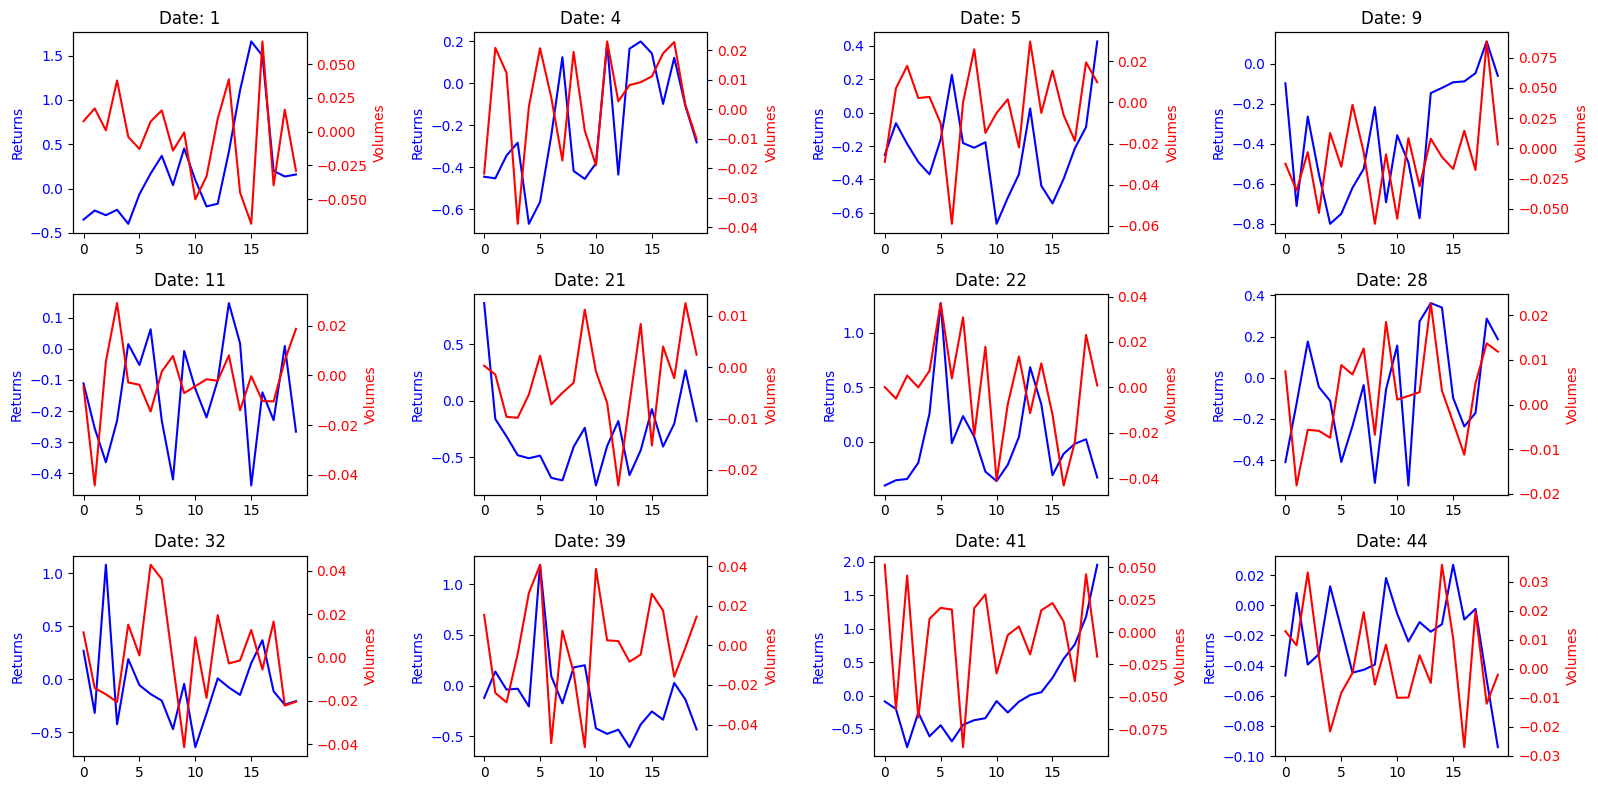

In [33]:
plot_return_volume_stock(train_complete_filled, stock, list_volumes, list_returns)

It seems like there is some sort of correlation between the volumes and the returns, this could certainly be useful to us. Let's try to quantify it in a more rigorous way. Also, let's see if that correaltion between the volume and the returns depends on the sector or other similar factors.

Let's note here that when we will be making predictions on a specific date later on, we won't have the volume on that specific date. Yet, we will have the volumes during the 20 days before that date. Hence, if we are able to get some signal/intuition looking at the 20-days-volumes series, and if we know there is a strong correlation between volumes and returns, we might be able to use that correlation to get information on the returns.

In [34]:
def get_all_vol_n_ret_dfs(all_stocks, train_complete_filled, list_volumes, list_returns):
    
    all_vol_n_ret_dfs = {}
    
    for stock in all_stocks:
        df = train_complete_filled.xs(stock, level='STOCK')
        df_volumes = df[list_volumes].T
        df_returns = df[list_returns].T
        all_vol_n_ret_dfs[stock] = (df_volumes, df_returns)
    
    return all_vol_n_ret_dfs

In [35]:
all_vol_n_ret_dfs_train = get_all_vol_n_ret_dfs(all_stocks, train_complete_filled, list_volumes, list_returns)
all_vol_n_ret_dfs_test = get_all_vol_n_ret_dfs(all_stock_test, x_test_filled, list_volumes, list_returns)

In [36]:
all_vol_n_ret_dfs_train[3][0]

DATE,0,6,7,10,18,19,20,25,33,34,...,183,186,193,194,198,203,204,214,218,223
VOLUME_1,-0.025600,-0.106387,-0.014510,-0.025994,0.006544,-0.090112,-0.056891,0.076562,-0.008540,0.035154,...,-0.088181,-0.154020,-0.055050,-0.047476,-0.089799,0.035588,-0.043650,-0.070855,-0.075252,-0.043710
VOLUME_2,-0.043549,-0.043071,0.035536,-0.051218,-0.027181,-0.064088,-0.041923,-0.065084,-0.052359,0.017814,...,-0.096266,-0.093825,-0.166571,-0.072088,-0.003781,-0.076800,-0.022489,-0.053482,-0.154530,-0.029596
VOLUME_3,-0.080412,-0.055744,-0.084132,-0.061910,-0.033828,-0.124321,-0.049801,-0.035473,-0.049115,-0.055930,...,-0.032314,-0.093151,-0.029577,-0.099956,-0.068574,-0.106646,0.015584,-0.034026,-0.044321,-0.040602
VOLUME_4,-0.090930,-0.087934,-0.028299,-0.024832,-0.129272,-0.060884,-0.080785,-0.044399,-0.070235,-0.036750,...,-0.057696,-0.131955,-0.039084,-0.025979,-0.068029,-0.130713,-0.000330,0.000640,-0.095008,-0.042633
VOLUME_5,-0.158444,-0.105722,-0.131385,-0.031105,-0.034926,-0.142088,-0.168318,-0.025163,-0.091833,-0.029004,...,-0.047806,-0.125506,-0.085585,-0.078507,-0.073280,-0.089186,-0.006507,0.004791,-0.058961,-0.064926
VOLUME_6,-0.079807,-0.045823,-0.071640,-0.013867,-0.024126,-0.043687,-0.107106,-0.057693,-0.087822,-0.096959,...,-0.035767,-0.106771,-0.034324,-0.054822,-0.170836,-0.205471,-0.013861,-0.009188,-0.045050,-0.048556
VOLUME_7,-0.049144,-0.040764,-0.077825,-0.020981,-0.009004,-0.091914,-0.029957,-0.059715,-0.076698,-0.028415,...,-0.069295,-0.133055,-0.039356,-0.087663,-0.037809,-0.064356,-0.035246,-0.000639,-0.032122,-0.005155
VOLUME_8,-0.075892,-0.047033,-0.074647,-0.038577,-0.026127,-0.075379,-0.065875,-0.055162,-0.095143,-0.060567,...,-0.020377,-0.102502,-0.026244,-0.048069,-0.077376,-0.067487,-0.008555,0.020448,-0.004950,-0.037153
VOLUME_9,-0.036215,-0.046598,-0.065822,-0.027323,-0.009090,-0.077683,-0.042895,-0.100268,-0.073004,-0.022057,...,-0.034221,-0.074892,-0.034025,-0.097691,-0.066102,-0.050744,-0.007250,-0.023562,-0.010540,-0.061867
VOLUME_10,-0.040319,-0.006130,-0.187697,-0.027709,-0.035938,-0.124148,-0.090405,-0.082857,-0.048243,-0.057806,...,-0.052898,-0.056712,-0.043334,-0.020240,-0.005661,-0.026865,-0.024074,-0.026484,-0.033560,-0.147831


In [37]:
def calculate_correlations(all_stocks, all_vol_n_ret_dfs):
    correlations = {}

    for stock in all_stocks:
        correlations[stock] = {}  
        for date in all_vol_n_ret_dfs[stock][0].columns:
            series1 = all_vol_n_ret_dfs[stock][0][date]
            series2 = all_vol_n_ret_dfs[stock][1][date]
            
            series1_reindexed = series1.reset_index(drop=True)
            series2_reindexed = series2.reset_index(drop=True)

            correlation_value = series1_reindexed.corr(series2_reindexed)
            
            correlations[stock][date] = correlation_value

    return correlations

In [38]:
correlations_vol_n_ret_train = calculate_correlations(all_stocks, all_vol_n_ret_dfs_train)
correlations_vol_n_ret_test = calculate_correlations(all_stock_test, all_vol_n_ret_dfs_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Now we have two dictionaries with, in it, for each stock, the correlations between the volumes and the returns at each date (for the 20 days before each day more precisely). Let's have a look.

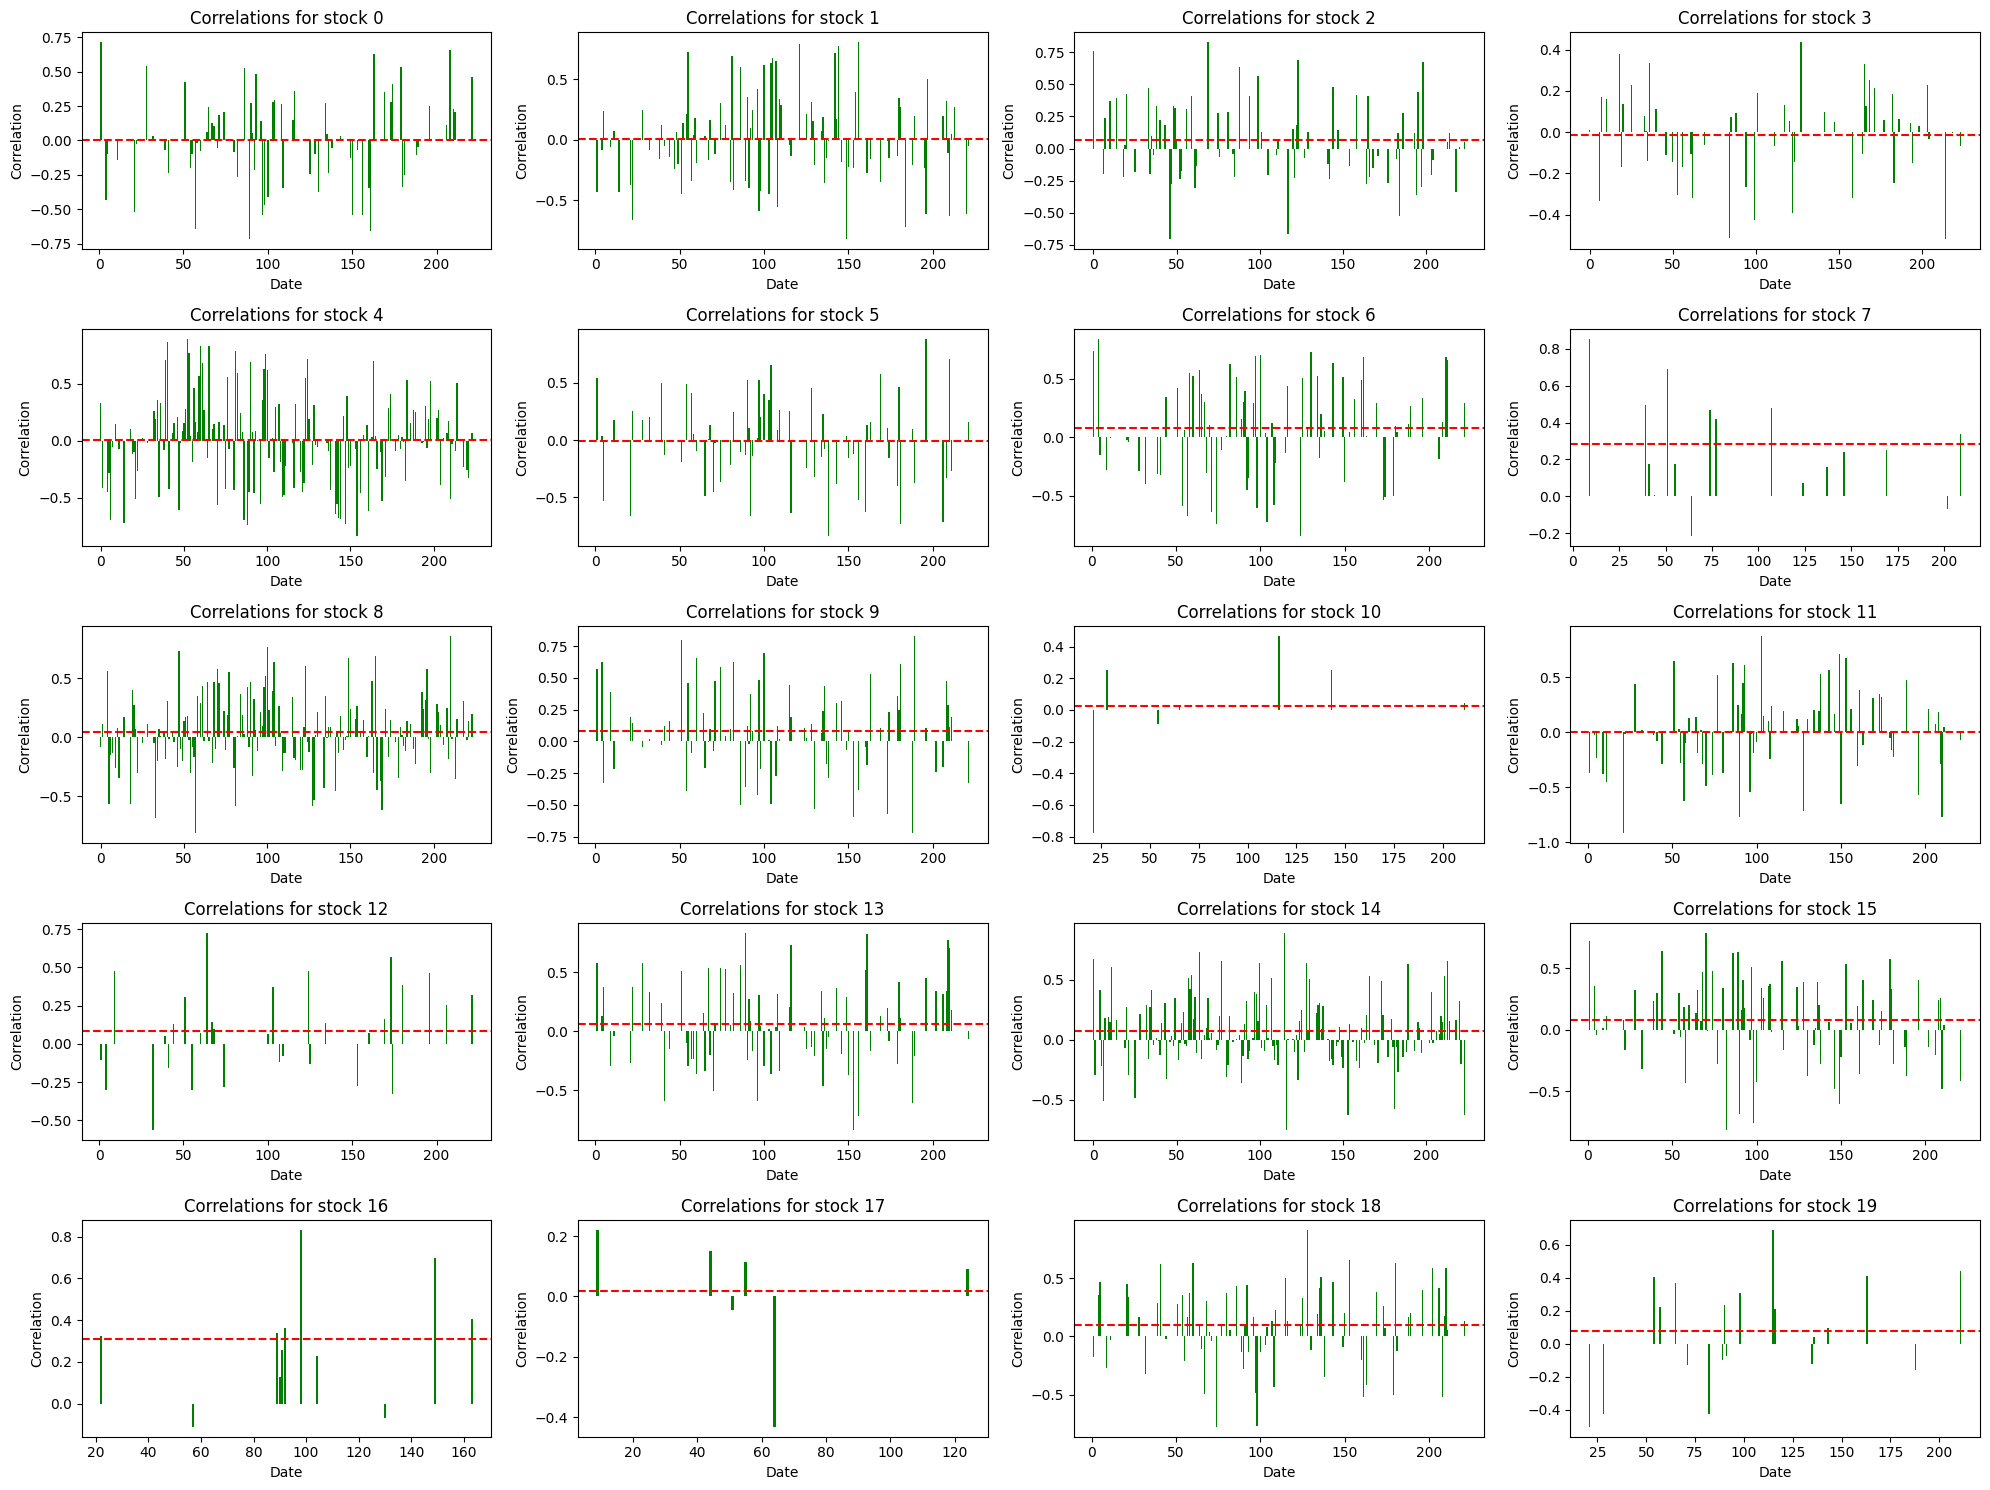

In [39]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

for i, stock in enumerate(all_stocks[:20]):
    ax = axes[i]
    stock_corr = correlations_vol_n_ret_train[stock]
    stock_dates = list(stock_corr.keys())
    stock_corr_values = list(stock_corr.values())
    
    ax.bar(stock_dates, stock_corr_values, color='green')
    
    mean_corr = np.nanmean(stock_corr_values)
    ax.axhline(y=mean_corr, color='red', linestyle='--', label=f'Mean Corr: {mean_corr:.2f}')
    
    ax.set_title(f'Correlations for stock {stock}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Correlation')
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()

From the above graph one can see that, although in general, the correlation is positive, it is very close to zero, and that, depending on the date, the correlation can be either negative or positive almost with equal chance. 

In [40]:
df_corr_train = pd.DataFrame.from_dict({(i, j): correlations_vol_n_ret_train[i][j] 
                             for i in correlations_vol_n_ret_train.keys() 
                             for j in correlations_vol_n_ret_train[i].keys()},
                            orient='index')

df_corr_train.index = pd.MultiIndex.from_tuples(df_corr_train.index, names=('STOCK', 'DATE'))

df_corr_test = pd.DataFrame.from_dict({(i, j): correlations_vol_n_ret_test[i][j] 
                             for i in correlations_vol_n_ret_test.keys() 
                             for j in correlations_vol_n_ret_test[i].keys()},
                            orient='index')

df_corr_test.index = pd.MultiIndex.from_tuples(df_corr_test.index, names=('STOCK', 'DATE'))

train_complete_filled = pd.concat([train_complete_filled,df_corr_train ], axis = 1)
x_test_filled = pd.concat([x_test_filled,df_corr_test ], axis = 1)

train_complete_filled = train_complete_filled.rename(columns={0: 'CORR_RET_VOLUME'})
x_test_filled = x_test_filled.rename(columns={0: 'CORR_RET_VOLUME'})

In [41]:
list_sector_types = ['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY', 'SUB_INDUSTRY']
list_features = ['MEAN_RET', 'MEAN_VOLUME', 'EMA_CR_5', 'EMA_CR_10', 'VOLATILITY', 'EMA_RET_10', 'EMA_RET_5', 'ROLLING_VOLATILITY_10', 'ROLLING_VOLATILITY_5', 'RET_1']

def plot_feature_correlations(train_complete_filled, list_sector_types, list_features):
    num_features = len(list_features)
    num_rows = (num_features + 1) // 2 
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 3 * num_rows))  
    axes = axes.flatten()

    for idx, feature in enumerate(list_features):
        correlations = []

        for sector_type in list_sector_types:
            grouped_mean = train_complete_filled.groupby(sector_type).mean()

            sorted_group = grouped_mean.sort_values(feature, ascending=False)
            correlation_value = sorted_group[feature].corr(sorted_group['RET'])
            correlations.append(correlation_value)

        ax = axes[idx]
        ax.bar(list_sector_types, correlations, color='green')
        ax.set_title(f'Correlation of {feature} with RET across sector/industries group types')
        ax.set_ylabel('Correlation')
        ax.set_xlabel('Sector Type')
        ax.tick_params(axis='x')

    plt.tight_layout()
    plt.show()

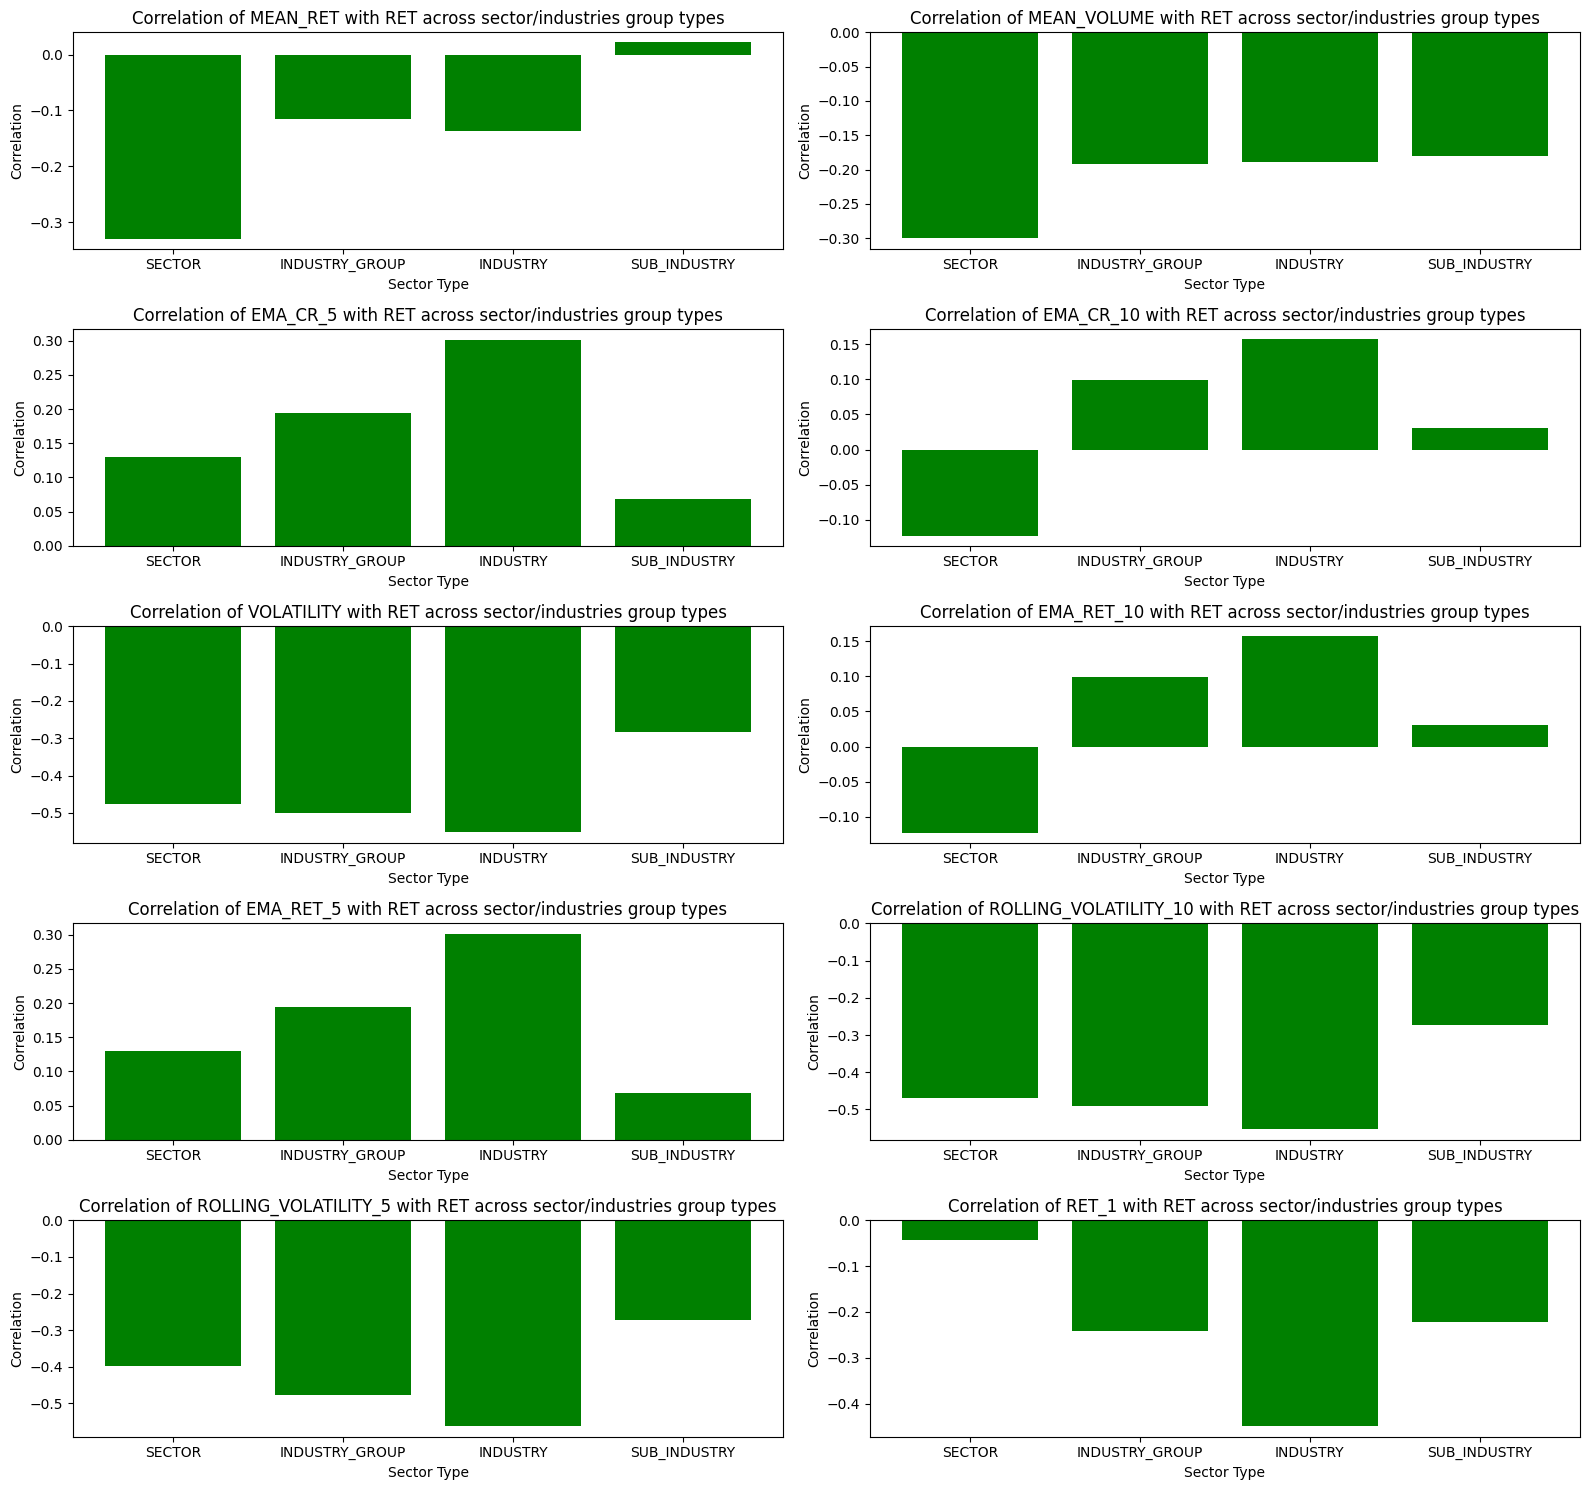

In [42]:
plot_feature_correlations(train_complete_filled, list_sector_types, list_features)

In the above function, what we do is that we group the data in different industry related groups (Sector/Indusry/sub_industry etc...) and then we compute the means of a certain feature (volatility for example) within each one of those groups and the means of the returns on the d-day for each one of those groups again. Then, we compute the correlation between the two series of means.

Interpretation: 

1. What we see is that the we have strong enough correlations or anti-correlations between the predicted returns and the features that we have used. This is interesting for us, indeed, we can now infer that those features will help us predict the returns when used in our model.

2. In more detail, one can see that, the graph with the features ROLLING_VOLATILITY_10, ROLLING_VOLATILITY_5 and VOLATILITY are pretty similar. In other words, these features, (in a group/sector) level, seem to be correlated in a similar manner to the returns. As we don't want to overcharge our training and testing dataframes, we will only keep features made out of one of these three features.
Similarly, we notice that MEAN_RET and EMA_CR_10 and EMA_RET_10 (respectively 5) are correlated in a same way with returns (which makes sense mathematically). Again, we will keep only one of these features at the end as we seek for new information on each column and we do not want to have dataframes with very much correlated columns.

3. Finally, one can see that depending on the feature studied, the sector/industry group with which we see more correlation changes. When creating new features, we will take that into consideration.


IMPORTANT NOTE : We use this graph to infer if indeed with the features present in our dataframe we can engineer some new useful features to predict the returns. However we must keep in mind two important things. First, it is important to not bring ANY LOOK AHEAD BIAS in our model. Hencen everytime we create an aggregated feature we must remember to aggregate on EACH SPECIFIC DATES. Indeed, if we only aggregate in sectors for instance, we will mix all the date and therefore necessarily bring a look ahead bias.
Second, one major issue that we want to avoid when training our model is to overfit. Hence, we will make sure that when we do feature engineering we actually aggregate at least on sub_industries at every date, so that we limit the noise.


In [43]:
train_complete_filled[['RET', 'ROLLING_VOLATILITY_10', 'ROLLING_VOLATILITY_5', 'SECTOR', 'EMA_CR_10', 'EMA_RET_10']].groupby(['SECTOR']).mean().corr()

,RET,ROLLING_VOLATILITY_10,ROLLING_VOLATILITY_5,EMA_CR_10,EMA_RET_10
RET,1.000000,-0.469401,-0.397800,-0.122837,-0.122837
ROLLING_VOLATILITY_10,-0.469401,1.000000,0.953887,0.425418,0.425418
ROLLING_VOLATILITY_5,-0.397800,0.953887,1.000000,0.184969,0.184969
EMA_CR_10,-0.122837,0.425418,0.184969,1.000000,1.000000
EMA_RET_10,-0.122837,0.425418,0.184969,1.000000,1.000000


So far, we have infered that some stocks that are calssified in a same group (same sector/ industry etc...) are likely to behave the same, and therefore we thought that it could be useful to do some computations/ engineer some features based on these groups. This might be useful indeed. However, stocks can have much other ways of being "close" than being in a same sector. Indeed, some stocks that are not in a same sector could also have some similar behavioral patterns, and similarly, some stocks that are in the same sectors could behave in a very different way.

Therefore, what we will do, is that for every single date, we will create our own clusters, based on returns, volumes or other features of the stocks.

In [44]:
def cluster_stocks_by_correlation(df, feature, features_columns, n_clusters=5):

    for date in df.index.get_level_values('DATE').unique():
        df_date = df.xs(date, level='DATE')

        returns = df_date[features_columns]
        correlation_matrix = returns.T.corr()
        correlation_matrix = correlation_matrix.fillna(0)
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        clusters = kmeans.fit_predict(correlation_matrix)

        df.loc[df.index.get_level_values('DATE') == date, f'cluster_{feature}'] = clusters

In [45]:
cluster_stocks_by_correlation(train_complete_filled, 'RET', list_returns)
cluster_stocks_by_correlation(train_complete_filled, 'VOLUME', list_volumes)

In [46]:
cluster_stocks_by_correlation(x_test_filled, 'RET', list_returns)
cluster_stocks_by_correlation(x_test_filled, 'VOLUME', list_volumes)

In [47]:
def create_groups_by_column_per_date(df, column_name):

    def qcut_within_date(group):
        group[f'Cluster_{column_name}'] = pd.qcut(group[column_name], q=5, labels=False, duplicates='drop') + 1
        return group

    df = df.groupby('DATE').apply(qcut_within_date)
    
    return df

In [48]:
train_complete_filled = create_groups_by_column_per_date(train_complete_filled, 'VOLATILITY')
x_test_filled = create_groups_by_column_per_date(x_test_filled, 'VOLATILITY')

In [49]:
train_complete_filled = create_groups_by_column_per_date(train_complete_filled, 'MEAN_RET')
x_test_filled = create_groups_by_column_per_date(x_test_filled, 'MEAN_RET')

In [50]:
train_complete_filled = create_groups_by_column_per_date(train_complete_filled, 'CORR_RET_VOLUME')
x_test_filled = create_groups_by_column_per_date(x_test_filled, 'CORR_RET_VOLUME')

We now have clusters of similar stocks for every single date which will certainly be useful to our use. However, it is imprtant to note that a cluster is specific to a date. Hence, two stocks can belong to cluster 2 for instance, without having any relation whatsoever (cluster number 2 at different date). If we give the information like that to a ML algorithm, there is a non negleactable chance that it will infer relationships (betweeen some stocks) that do not exist. Hence, it is important that we use that cluster information only when creating features specific to a certain date.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

def plot_clusters_and_sectors(df, return_columns, feature, n_clusters=5, n_dates=20):

    dates = df.index.get_level_values('DATE').unique()[:n_dates]
    fig, axes = plt.subplots(10, 2, figsize=(20, 40))
    axes = axes.flatten()

    sector_colors = list(mcolors.TABLEAU_COLORS.values())[:-1]
    markers = ['o', 'x', '^', 's', 'D'][:n_clusters]

    for idx, date in enumerate(dates):
        df_date = df.xs(date, level='DATE')
        returns = df_date[return_columns]

        if returns.ndim == 1:
            returns = returns.to_frame().T
        scaler = StandardScaler()
        returns_scaled = scaler.fit_transform(returns)

        pca = PCA(n_components=2)
        pca_components = pca.fit_transform(returns_scaled)
        ax = axes[idx]

        for cluster in range(n_clusters):
            cluster_data = df_date[df_date[f'cluster_{feature}'] == cluster]
            if len(cluster_data) == 0:
                continue
            
            sector_colors_for_stocks = [sector_colors[i % len(sector_colors)] for i in cluster_data['SECTOR'].astype('category').cat.codes]

            ax.scatter(
                pca_components[df_date[f'cluster_{feature}'] == cluster, 0], 
                pca_components[df_date[f'cluster_{feature}'] == cluster, 1],  
                c=sector_colors_for_stocks, 
                marker=markers[cluster], 
                label=f'Cluster {cluster}',
                alpha=0.7
            )

        ax.set_title(f"Date: {date}")
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")

    handles, labels = ax.get_legend_handles_labels()
    black_handles = [plt.Line2D([], [], color='black', marker=markers[i], linestyle='None', markersize=10, label=labels[i]) for i in range(n_clusters)]
    
    fig.legend(handles=black_handles, loc='upper right', title='Clusters')

    plt.tight_layout()
    plt.show()

In [52]:
def remove_duplicate_columns(df):
    df = df.loc[:, ~df.columns.duplicated()]
    if df.index.duplicated().any():
        df = df.reset_index()
        df = df.loc[:, ~df.columns.duplicated()]
        df = df.set_index(df.columns[0]) 

    return df

In [53]:
train_complete_filled = train_complete_filled.droplevel([0,1,2])
x_test_filled = x_test_filled.droplevel([0,1,2])

In [54]:

train_complete_filled = train_complete_filled.sort_values(['STOCK', 'DATE'])
x_test_filled = x_test_filled.sort_values(['STOCK', 'DATE'])

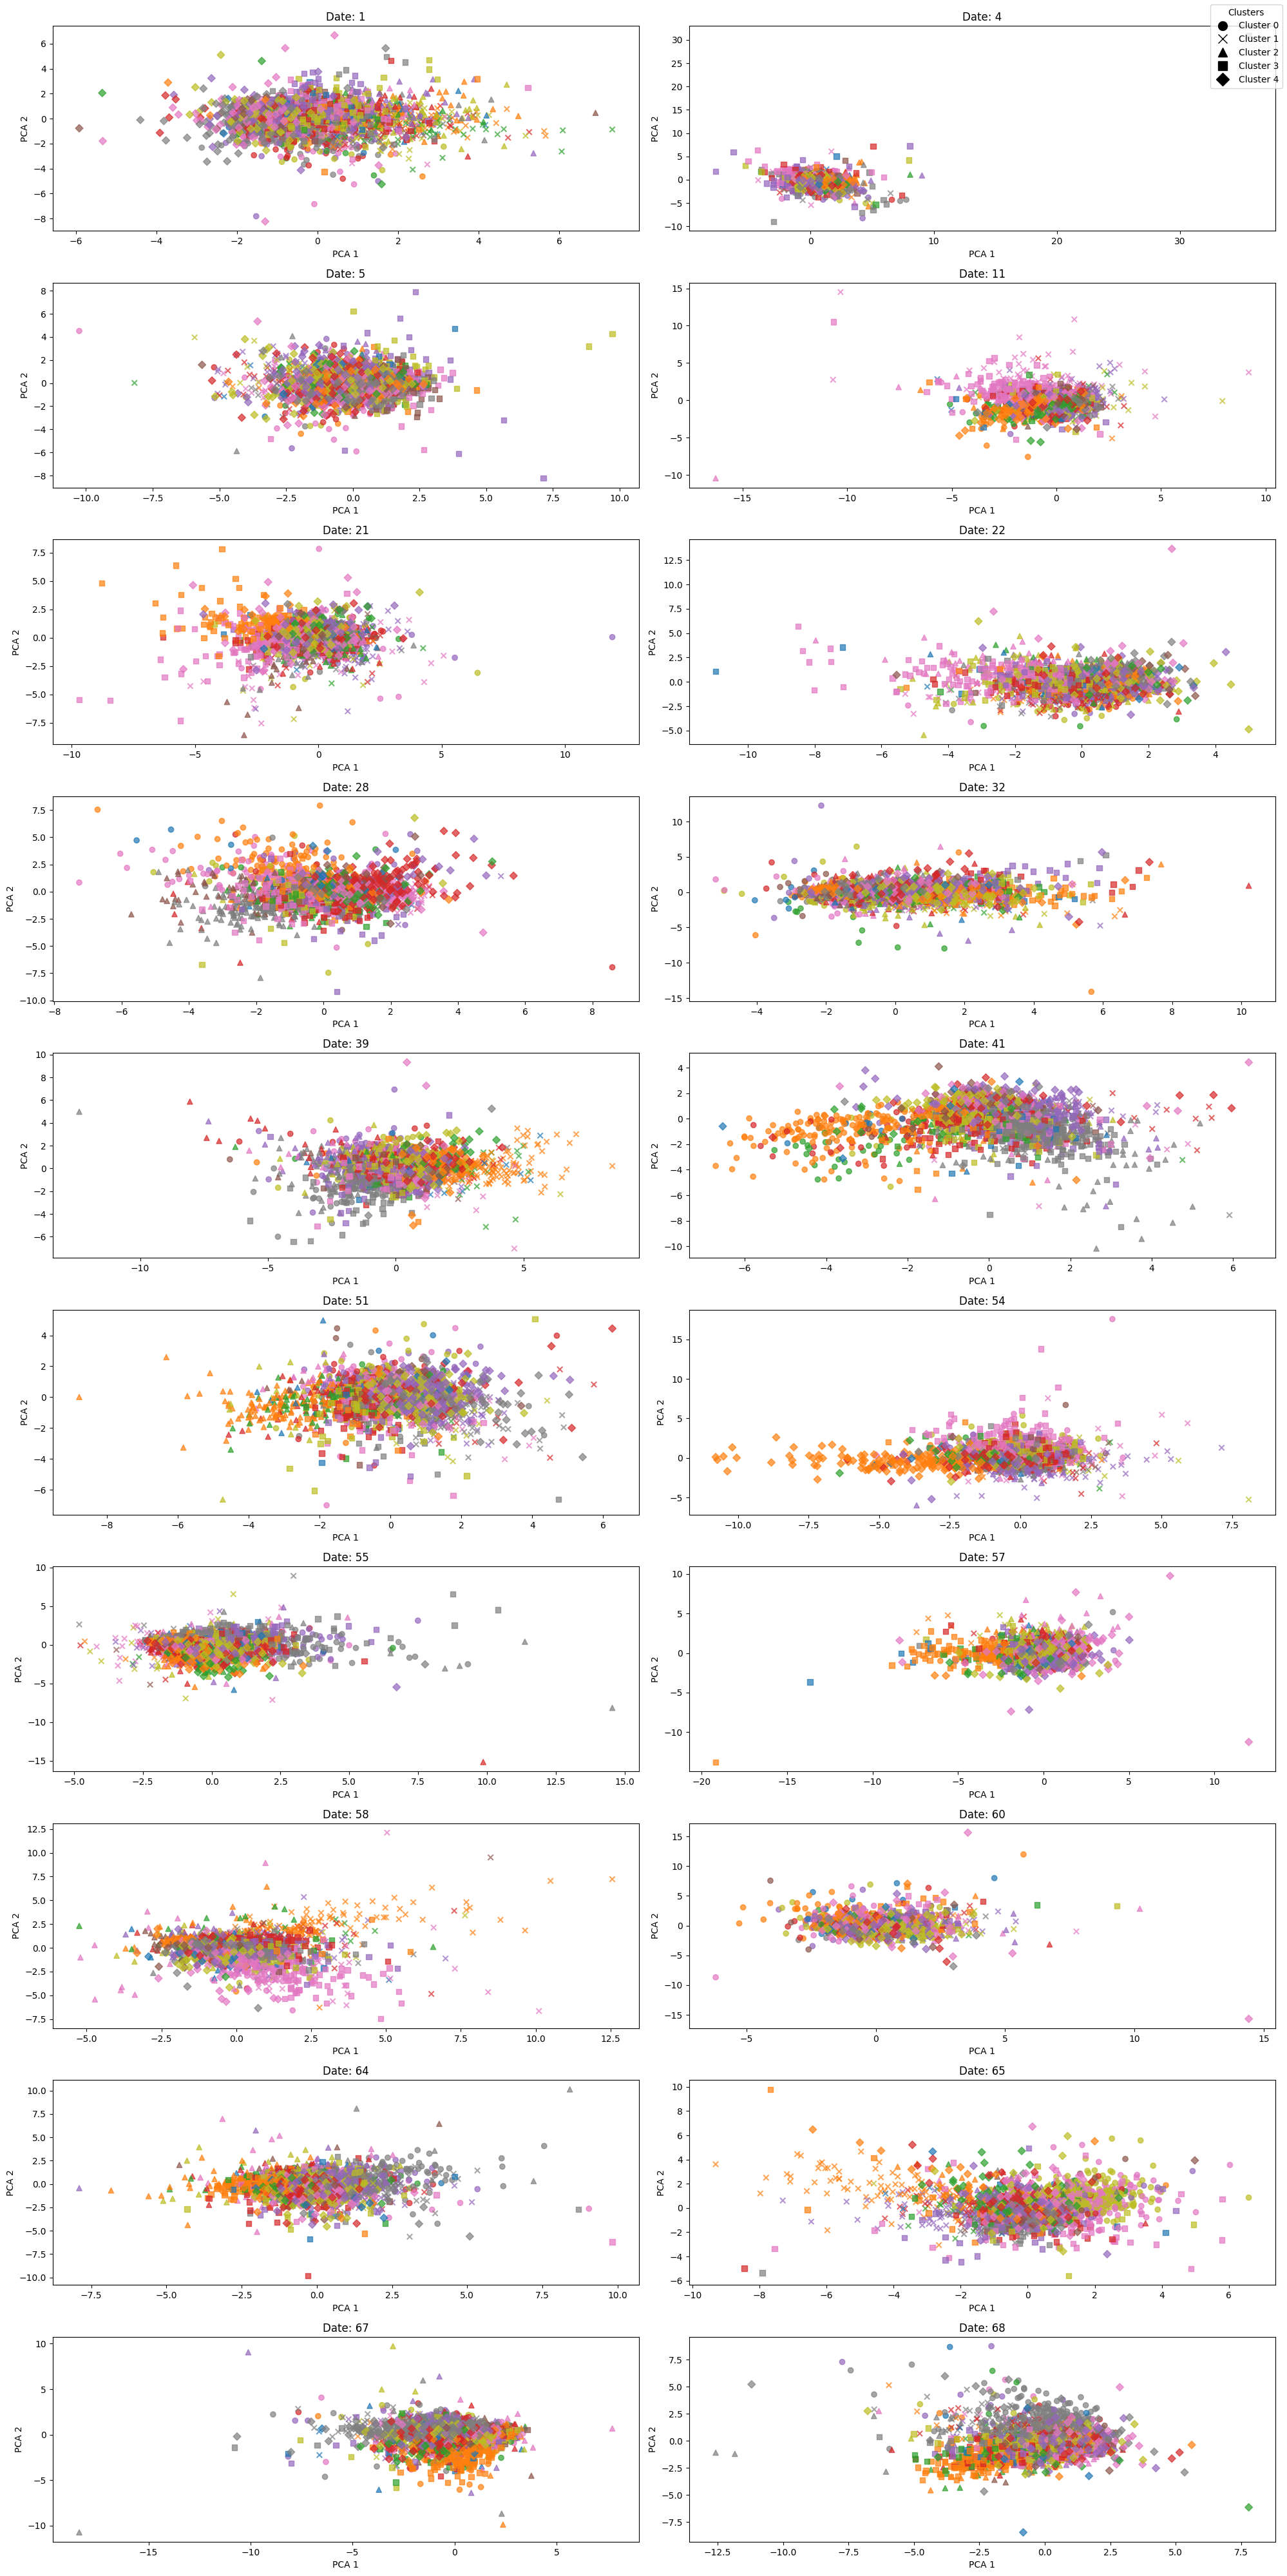

In [55]:
plot_clusters_and_sectors(train_complete_filled, list_returns, 'RET', n_clusters=5, n_dates=20)

From the above graph, one can see that it seems to be some correlation between the shape and the color, meaning that the sectors and the clusters catch to some extend some same information. 

However, one can see that this correlation is far from being perfect, with some shapes coming in mutiple colors and forming different areas of the graphs from the ones created by the sectors. This means that the clusters capture some information that is not captured fby the sector. Ultimately, we can infer that clustering stocks on specific dates can be useful to improve the performance of our algorithm !

## 6. Feature Engineering

Let's now use the observations made in the previous part to engineer some new feature that could be useful for our predictions.

In [56]:
def add_aggregated_feature(df, group_by_columns, feature_column, stat_function='mean'):

    new_column_name = f'{feature_column}_{stat_function}_by_' + '_'.join(group_by_columns)
    aggregated = df.groupby(group_by_columns)[feature_column].transform(stat_function)
    df[new_column_name] = aggregated
    
    return df

In [57]:
def apply_aggregated_features_to_conditions(dfs, conditions):

    for i, df in enumerate(dfs):
        for groups_by, features, statistic in conditions:
            for feature in features:
                for stat in statistic:
                    # Appliquer la fonction d'agrégation
                    df = add_aggregated_feature(df, groups_by, feature, stat)

        dfs[i] = df
    
    return dfs

In [58]:
conditions = [
    (['DATE', 'SECTOR'], ['RET_3','RET_4','RET_2' ,'VOLUME_1','EMA_CR_5','Momentum_ratio'], ['mean']),
    (['DATE', 'Cluster_VOLATILITY'], ['RET_1', 'RET_2', 'VOLUME_1', ], ['mean']),
    (['DATE', 'INDUSTRY_GROUP'], ['RET_1','MEAN_RET','VOLATILITY', 'positive_volumes_last_20', 'positive_returns_last_20'], ['mean']),
    (['DATE', 'INDUSTRY_GROUP'], ['Momentum_ratio'], ['mean'])
]

dfs = [train_complete_filled, x_test_filled]
dfs = apply_aggregated_features_to_conditions(dfs, conditions)


In [59]:
train_complete_filled.columns[87:]

Index(['RET_3_mean_by_DATE_SECTOR', 'RET_4_mean_by_DATE_SECTOR',
       'RET_2_mean_by_DATE_SECTOR', 'VOLUME_1_mean_by_DATE_SECTOR',
       'EMA_CR_5_mean_by_DATE_SECTOR', 'Momentum_ratio_mean_by_DATE_SECTOR',
       'RET_1_mean_by_DATE_Cluster_VOLATILITY',
       'RET_2_mean_by_DATE_Cluster_VOLATILITY',
       'VOLUME_1_mean_by_DATE_Cluster_VOLATILITY',
       'RET_1_mean_by_DATE_INDUSTRY_GROUP',
       'MEAN_RET_mean_by_DATE_INDUSTRY_GROUP',
       'VOLATILITY_mean_by_DATE_INDUSTRY_GROUP',
       'positive_volumes_last_20_mean_by_DATE_INDUSTRY_GROUP',
       'positive_returns_last_20_mean_by_DATE_INDUSTRY_GROUP',
       'Momentum_ratio_mean_by_DATE_INDUSTRY_GROUP'],
      dtype='object')

## 7. Feature Selection

In [60]:
new_features = list(train_complete_filled.columns[87:])

In [82]:
x_test_filled = x_test_filled.reset_index()
x_test_filled.set_index('ID', inplace=True)

train_complete_filled = train_complete_filled.loc[:, ~train_complete_filled.columns.duplicated()]
train_complete_filled = train_complete_filled.reset_index()
train_complete_filled.set_index('ID', inplace=True)

train_complete_filled = train_complete_filled.sort_index()
x_test_filled = x_test_filled.sort_index()

In [85]:
target = 'RET'

n_shifts = 4  
features = ['RET_1', 'RET_2', 'RET_3' ,'MEAN_RET']
features += ['VOLUME_1', 'VOLUME_2']
features += new_features  
train_complete_filled[features].head()

,RET_1,RET_2,RET_3,MEAN_RET,VOLUME_1,VOLUME_2,RET_3_mean_by_DATE_SECTOR,RET_4_mean_by_DATE_SECTOR,RET_2_mean_by_DATE_SECTOR,VOLUME_1_mean_by_DATE_SECTOR,...,Momentum_ratio_mean_by_DATE_SECTOR,RET_1_mean_by_DATE_Cluster_VOLATILITY,RET_2_mean_by_DATE_Cluster_VOLATILITY,VOLUME_1_mean_by_DATE_Cluster_VOLATILITY,RET_1_mean_by_DATE_INDUSTRY_GROUP,MEAN_RET_mean_by_DATE_INDUSTRY_GROUP,VOLATILITY_mean_by_DATE_INDUSTRY_GROUP,positive_volumes_last_20_mean_by_DATE_INDUSTRY_GROUP,positive_returns_last_20_mean_by_DATE_INDUSTRY_GROUP,Momentum_ratio_mean_by_DATE_INDUSTRY_GROUP
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,0.016318,0.147931,0.179183,-0.000148,-0.000655,-0.017313,0.006335,...,89.679697,0.015713,-0.043826,0.207268,0.011825,0.004682,2.929096,6.142857,10.904762,84.842089
1,0.003984,-0.090580,0.018826,-0.005572,-0.025600,-0.043549,-0.008673,-0.003666,-0.023300,0.008140,...,98.790092,0.015713,-0.043826,0.207268,0.002373,0.001871,3.582783,3.628931,9.874214,100.045936
2,0.000440,-0.058896,-0.009042,-0.001043,-0.096282,0.084771,-0.011702,-0.000986,-0.044975,0.120808,...,89.602753,0.007527,-0.018088,-0.066321,0.015492,0.003515,3.908968,5.731579,10.189474,90.567135
3,0.031298,0.007756,-0.004632,-0.003154,-0.429540,-0.089919,-0.014219,-0.009237,0.001304,-0.121974,...,91.972139,0.007527,-0.018088,-0.066321,0.017253,-0.001611,2.014373,4.644444,8.822222,91.972139
4,0.027273,-0.039302,0.000000,-0.003551,-0.847155,-0.943033,-0.004146,-0.000578,-0.014918,-0.186855,...,97.739323,0.006682,-0.031028,-0.026574,0.006210,0.000137,1.826195,6.054545,9.472727,91.873541


In [116]:
X_train = train_complete_filled[features]
y_train = train_complete_filled[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 8,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train_complete_filled['DATE'].unique()
test_dates = x_test_filled['DATE'].unique() 

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train_complete_filled['DATE'].isin(local_train_dates)
    local_test_ids = train_complete_filled['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]
    
    X_local_train = X_local_train.fillna(0)  
    X_local_test = X_local_test.fillna(0)  

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train_complete_filled.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.79%
Fold 2 - Accuracy: 51.52%
Fold 3 - Accuracy: 52.15%
Fold 4 - Accuracy: 52.18%
Accuracy: 51.91% [51.63 ; 52.18] (+- 0.27)


In [112]:
import seaborn as sns

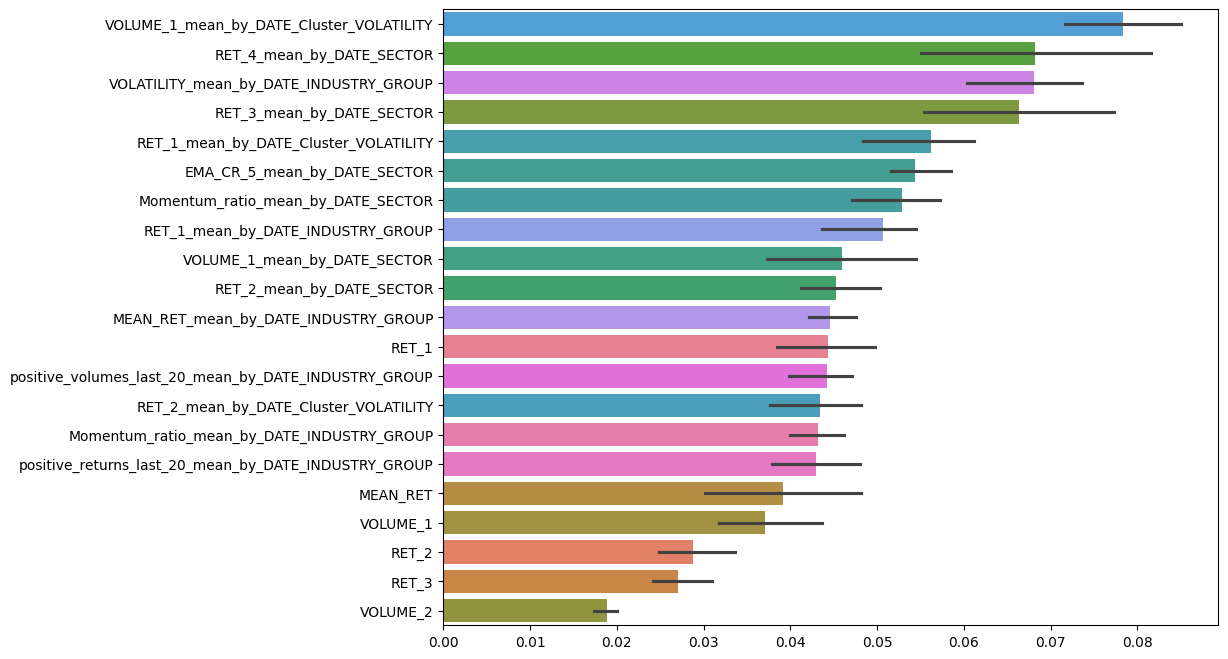

In [113]:
plt.figure(figsize=(10, 8))

feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)
plt.show()

In [114]:
X_test = x_test_filled[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = x_test_filled.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = x_test_filled.index
submission.name = target

submission.to_csv('./samy_kob_sub_sk5.csv', index=True, header=True)

In [115]:
submission

ID
418595    False
418596    False
418597     True
418598     True
418599     True
          ...  
617019     True
617020     True
617021     True
617022    False
617023     True
Name: RET, Length: 198429, dtype: bool

## 8. Ideas for improvement

To further improve the prediction, one potential direction would be to ex-
plore the use of a fixed-effects model. This approach could help capture
unobserved heterogeneity across stocks or time periods by controlling for
characteristics that remain constant over time within each entity. I tried
similar local technique with XGBoost but overfitting was an issue.
Another avenue that could be interesting would be the use of a Panel Tree
(P-Tree) model, on which I read an article recently. As introduced by Cong,
Feng, He, and He (2022) [2]. The P-Tree model is specifically designed for
handling panel data by splitting the cross-section of asset returns based on
a global no-arbitrage condition, while also capturing nonlinear interactions.
This model offers a balance between interpretability and predictive perfor-
mance and can help reduce the risk of overfitting by leveraging a global
splitting criterion. Such techniques could prove highly valuable in enhancing
the robustness and accuracy of our predictive models.